In [186]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_rows=1000
import glob2

In [176]:
#combine differnt files
# filenames = glob2.glob('*.txt') 
# with open('final_file', 'w') as outfile:
#     for fname in filenames:
#         with open(fname) as infile:
#             for line in infile:
#                 outfile.write(line)

In [187]:
Jan05= pd.read_csv('Jan05-19.txt')

In [178]:
Jan05.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES',
       'EXITS                                                               '],
      dtype='object')

In [188]:
Jan05.isnull().sum()

C/A                                                                     0
UNIT                                                                    0
SCP                                                                     0
STATION                                                                 0
LINENAME                                                                0
DIVISION                                                                0
DATE                                                                    0
TIME                                                                    0
DESC                                                                    0
ENTRIES                                                                 0
EXITS                                                                   0
dtype: int64

In [189]:
Jan05.isna().sum()

C/A                                                                     0
UNIT                                                                    0
SCP                                                                     0
STATION                                                                 0
LINENAME                                                                0
DIVISION                                                                0
DATE                                                                    0
TIME                                                                    0
DESC                                                                    0
ENTRIES                                                                 0
EXITS                                                                   0
dtype: int64

In [181]:
Jan05.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201603 entries, 0 to 201602
Data columns (total 11 columns):
C/A                                                                     201603 non-null object
UNIT                                                                    201603 non-null object
SCP                                                                     201603 non-null object
STATION                                                                 201603 non-null object
LINENAME                                                                201603 non-null object
DIVISION                                                                201603 non-null object
DATE                                                                    201603 non-null object
TIME                                                                    201603 non-null object
DESC                                                                    201603 non-null object
ENTRIES                           

In [182]:
Jan05.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,03:00:00,REGULAR,6889287,2335920
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,07:00:00,REGULAR,6889299,2335936
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,11:00:00,REGULAR,6889364,2336038
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,15:00:00,REGULAR,6889605,2336101
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,19:00:00,REGULAR,6889966,2336173


In [190]:
Jan05.columns=[col.strip() for col in Jan05.columns]
Jan05.columns

Index(['C/A', 'UNIT', 'SCP', 'STATION', 'LINENAME', 'DIVISION', 'DATE', 'TIME',
       'DESC', 'ENTRIES', 'EXITS'],
      dtype='object')

In [192]:
Jan05['DATE & TIME']=Jan05['DATE'] +' '+ Jan05['TIME']
Jan05.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE & TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,03:00:00,REGULAR,6889287,2335920,12/29/2018 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,07:00:00,REGULAR,6889299,2335936,12/29/2018 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,11:00:00,REGULAR,6889364,2336038,12/29/2018 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,15:00:00,REGULAR,6889605,2336101,12/29/2018 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,19:00:00,REGULAR,6889966,2336173,12/29/2018 19:00:00


In [193]:
Jan05['DATE & TIME'] = pd.to_datetime(Jan05['DATE & TIME'])

In [ ]:
Jan05.info()

In [194]:
#drop date and time columns
Jan05.drop(columns=['DATE','TIME'])

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DESC,ENTRIES,EXITS,DATE & TIME
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6889287,2335920,2018-12-29 03:00:00
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6889299,2335936,2018-12-29 07:00:00
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6889364,2336038,2018-12-29 11:00:00
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6889605,2336101,2018-12-29 15:00:00
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6889966,2336173,2018-12-29 19:00:00
5,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6890186,2336219,2018-12-29 23:00:00
6,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6890230,2336231,2018-12-30 03:00:00
7,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6890237,2336242,2018-12-30 07:00:00
8,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6890279,2336288,2018-12-30 11:00:00
9,A002,R051,02-00-00,59 ST,NQR456W,BMT,REGULAR,6890428,2336357,2018-12-30 15:00:00


In [195]:
Jan05['DAY OF WEEK']=Jan05['DATE & TIME'].dt.day_name()
Jan05.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS,DATE & TIME,DAY OF WEEK
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,03:00:00,REGULAR,6889287,2335920,2018-12-29 03:00:00,Saturday
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,07:00:00,REGULAR,6889299,2335936,2018-12-29 07:00:00,Saturday
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,11:00:00,REGULAR,6889364,2336038,2018-12-29 11:00:00,Saturday
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,15:00:00,REGULAR,6889605,2336101,2018-12-29 15:00:00,Saturday
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,12/29/2018,19:00:00,REGULAR,6889966,2336173,2018-12-29 19:00:00,Saturday


In [ ]:
Jan05.groupby('DAY OF WEEK').count()

In [ ]:
# Jan05.groupby('DAY OF WEEK').count()['ENTRIES'].plot()
# Jan05.groupby('DAY OF WEEK').count()['EXITS'].plot()
Jan05['ENTRIES DIFF']=Jan05.groupby('STATION')['ENTRIES'].diff()

In [198]:
Jan05['ENTRIES DIFF']=Jan05.groupby('STATION')['ENTRIES'].diff()
Jan05['EXITS DIFF']=Jan05.groupby('STATION')['EXITS'].diff()

In [ ]:
#We want to combine the numbers together -- 
#for each ControlArea/UNIT/STATION combo, 
#for each day, add the counts from each turnstile belonging to that combo.
#this can make a plot
# df_entries = pd.DataFrame(Jan05.groupby(['C/A','UNIT','STATION',Jan05['DATE & TIME'].dt.date])['ENTRIES'].count())
# df_entries

In [199]:
Jan05[Jan05['ENTRIES DIFF']<0].count()
#since we have 2% of the dirty data, we can drop the data

C/A             3927
UNIT            3927
SCP             3927
STATION         3927
LINENAME        3927
DIVISION        3927
DATE            3927
TIME            3927
DESC            3927
ENTRIES         3927
EXITS           3927
DATE & TIME     3927
DAY OF WEEK     3927
ENTRIES DIFF    3927
EXITS DIFF      3927
dtype: int64

In [ ]:
Jan05[Jan05['EXITS DIFF']<0].count()

In [ ]:
Jan05[(Jan05['ENTRIES DIFF']<0) & (Jan05['EXITS DIFF']<0)].count()

In [ ]:
Jan05[(Jan05['ENTRIES DIFF']<0) | (Jan05['EXITS DIFF']<0)].count()

In [200]:
Jan05['ENTRIES DIFF'].isna().sum()

377

In [ ]:
Jan05['EXITS DIFF'].isna().sum()

In [201]:
#dropping the negative difference and nan
Jan05=Jan05.drop(Jan05[Jan05['ENTRIES DIFF'] < 0].index)
Jan05=Jan05.drop(Jan05[Jan05['EXITS DIFF'] < 0].index)
Jan05=Jan05.dropna()

In [205]:
Jan05.isna().sum()

C/A             0
UNIT            0
SCP             0
STATION         0
LINENAME        0
DIVISION        0
DATE            0
TIME            0
DESC            0
ENTRIES         0
EXITS           0
DATE & TIME     0
DAY OF WEEK     0
ENTRIES DIFF    0
EXITS DIFF      0
dtype: int64

In [206]:
Jan05['ENTRIES DIFF'].groupby([Jan05['DATE & TIME'].dt.date]).sum()

DATE & TIME
2018-12-29    1.414253e+11
2018-12-30    9.872850e+09
2018-12-31    1.258799e+09
2019-01-01    2.317568e+06
2019-01-02    5.219254e+06
2019-01-03    5.508161e+06
2019-01-04    5.455555e+06
Name: ENTRIES DIFF, dtype: float64

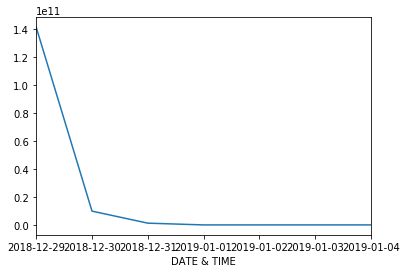

In [207]:
df = Jan05.groupby([Jan05['DATE & TIME'].dt.date])['ENTRIES DIFF'].sum().plot()
df
#from the plot, we can see 2019-01-04 has the most entries

In [ ]:
plt.figure(figsize = [10,5])
plt.plot(Jan05_Entry)
#need to add day of week

In [ ]:
Jan05.groupby(['DATE']).apply(lambda x: x.sort_values(['Entries', 'Exits']))

In [ ]:
#station name cleansing
#the strip() removes characters from both left and right based on the argument
Jan05['STATION']=[name.strip() for name in Jan05.STATION]

In [ ]:
#What is the average number of entries per station per day?

In [ ]:
Jan05['DATE']=pd.to_datetime(Jan05.DATE)

In [ ]:
Jan05['Day_Of_Week']=Jan05.DATE.dt.weekday_name

In [ ]:
Jan05.head()